# ASEN 6519 Fall 2018 - Midterm Project 
## Extended KF and Ensemble Filters with Lorenz-63

### The Lorenz-63 Model
Low-dimensional model: the state is made of 3 variables $x = (x1, x2, x3)$ and dynamical system evolution is given by the following equations:

$$\frac{\partial x_1}{\partial t} = -Ax_1 + Ax_2$$
$$\frac{\partial x_2}{\partial t} = Bx_1 - x_1x_3 - x_2$$
$$\frac{\partial x_3}{\partial t} = x_1x_2 - Cx_3$$

where $A=10$, $B=28$, and $C=8/3$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def dfdt(r, coeffs):
    '''
    Returns dx1/dt, dx2/dt, dx3/dt
    '''
    # Current position
    x1 = r[0]
    x2 = r[1]
    x3 = r[2]
    
    # Extract coefficients
    A = coeffs[0]
    B = coeffs[1]
    C = coeffs[2]
    
    # Calculate the derivative
    dx1 = -A*x1 + A*x2
    dx2 = B*x1 - x1*x3 - x2
    dx3 = x1*x2 - C*x3
    
    return np.array([dx1, dx2, dx3], float)

### 1. Generate $true$ state and synthetic observations using Lorenz63 setup with the default inputs.

In [3]:
def advance_time(r, coeffs, h):
    '''
    Calculate the state of the system at time t+1 using RK4
    
    Inputs:
        r - the state
        coeffs - the standard Lorenz system coefficients
        h - timstep
    '''
    
    # Calculate Runge-Kutta4 coefficients
    k1 = h*dfdt(r, coeffs)
    k2 = h*dfdt(r+0.5*k1, coeffs)
    k3 = h*dfdt(r+0.5*k2, coeffs)
    k4 = h*dfdt(r+k3, coeffs)
    
    # Update current position
    r += (k1 + 2*k2 + 2*k3 + k4)/6
    
    return r

#### Setup Model

In [4]:
## Model setup  (Do not change)
N_state = 3 # Number of state variables
MO = 3      # Number of measurement variables

A_lor = 10  # Default Lorenz system parameters
B_lor = 28
C_lor = 8/3
coeffs = np.array([A_lor, B_lor, C_lor],float)

# Numerical parameters
t0 = 0          # sec, initial time
tf_assim = 3    # sec, final time   of forecast
tf_fore = 1     # sec, final length of forecast
h_sys = 0.01    # sec, timestep for system dynamics
dyn2meas = 20   # Number of dynamics updates per measurement
h_obs = h_sys * dyn2meas     # sec; an observation is generated every h_obs sec
t_sys = np.arange(t0,tf_assim,h_sys)     # time stamps for system dynamics
t_obs = np.arange(t0,tf_assim,h_obs)     # time stamps for observations
N_sys = len(t_sys)               # Number of system timesteps
N_obs = len(t_obs)               # Number of observations

## Initial conditions
x_true = np.zeros([N_state, N_sys])  # True history of x1 (without any noise)
x_s = np.zeros([N_state, N_sys])     # Noisy history of x1 (with process noise)
y = np.zeros([MO, N_obs])  # Measurements of x1 (with measurement noise)

# default input parameters, she uses 'astr' name
x1_0 = 1.5
x2_0 = -1.5
x3_0 = 25.5

#### Setup Errors/Covariances

In [5]:
## Background error variance
var_b = 1   
B_struct = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]])
B_cov = var_b * B_struct

# Note: dont have usehigh order scheme
# note forget about Q
## Model error covariance (ie: process noise), from Evensen 1997
Q = np.zeros((3,3))
Q[0,0] = 0.1491
Q[0,1] = 0.1505
Q[0,2] = 0.0007
Q[1,0] = 0.1505
Q[1,1] = 0.9048
Q[1,2] = 0.0014
Q[2,0] = 0.0007
Q[2,1] = 0.0014
Q[2,2] = 0.9180
# Qsqrt_cov = np.linalg.cholesky(Q)
L, V = np.linalg.eig(Q)
Qsqrt_cov = V*np.sqrt(L)    # TODO: Why this?

## Misc errors which I do not understand yet but need to run the system
varobs = 3   # Observation error variance
svar = 0.3

## Measurement covariance
sobs = np.sqrt(varobs)
R_struct = np.eye(3)
R = varobs * R_struct
L, V = np.linalg.eig(R)
Msqrt_cov = V*np.sqrt(L)

# ## Generate all the process noise ahead of time
# pnoise_seed = np.random.randn(MO, N_sys)
# pnoise = Qsqrt_cov @ pnoise_seed

#### Run the System: Generate States ($x_{true}$)

In [6]:
## Iterate through time and simulate dynamics
r = np.array([[x1_0, x2_0, x3_0]], float).T   # "Current" position

## Set ICs
x_true[:,0] = np.squeeze(r)
x_s[:,0] = np.squeeze(r + svar * np.random.randn(3,1))

for i in range(1,N_sys):
#     # Current time step (i)
#     x_true[:,i] = np.squeeze(r)
    
    # Advance time step (i+1)
    x_true[:,i] = advance_time(x_true[:,i-1], coeffs, h_sys)
    x_s[:,i] = advance_time(x_s[:,i-1], coeffs, h_sys) + \
                np.squeeze(Qsqrt_cov @ np.random.randn(3,1))

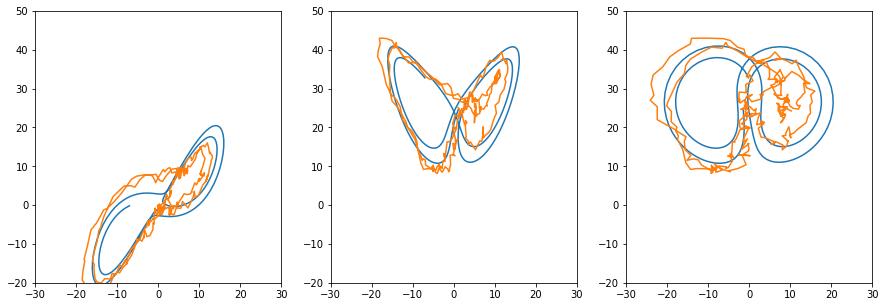

In [7]:
plt.figure(figsize=[15,5])
plt.subplot(1,3,1) ; plt.plot(x_true[0,:],x_true[1,:]);plt.ylim(-20,50);plt.xlim(-30,30)
plt.plot(x_s[0,:],x_s[1,:])

plt.subplot(1,3,2)
plt.plot(x_true[0,:],x_true[2,:]); plt.ylim(-20,50);plt.xlim(-30,30)
plt.plot(x_s[0,:],x_s[2,:]) 

plt.subplot(1,3,3) ; plt.plot(x_true[1,:],x_true[2,:]);plt.ylim(-20,50);plt.xlim(-30,30)
plt.plot(x_s[1,:],x_s[2,:])
plt.show()

#### Generate Measurements

In [8]:
for i in range(N_obs):
    # this reads in states from 0 to 300 in increments of 20 to get even spread of obseravations
    # [:,np.newaxis] makes dimensions from 3, to 3x1.
    curr_state = x_true[:,i*dyn2meas][:,np.newaxis]
    # for each state selected, obs = Measurement covariance + randomness
    y[:,i] = np.squeeze(curr_state + Msqrt_cov @ np.random.randn(3,1))

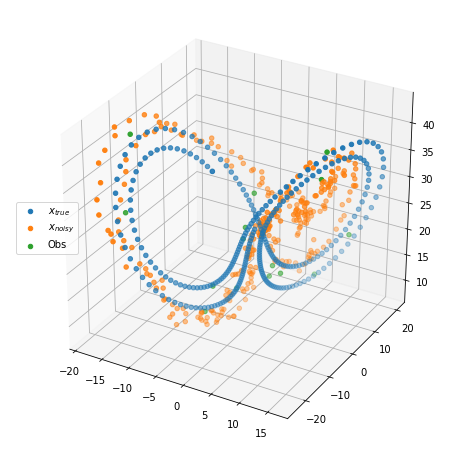

In [9]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_true[0,:],x_true[1,:],x_true[2,:],label='$x_{true}$')
ax.scatter(x_s[0,:],x_s[1,:],x_s[2,:],label='$x_{noisy}$')#,s=100,marker='x')
ax.scatter(y[0,:],y[1,:],y[2,:],label='Obs')#,s=100,marker='x')
ax.legend(loc=6)
plt.show()

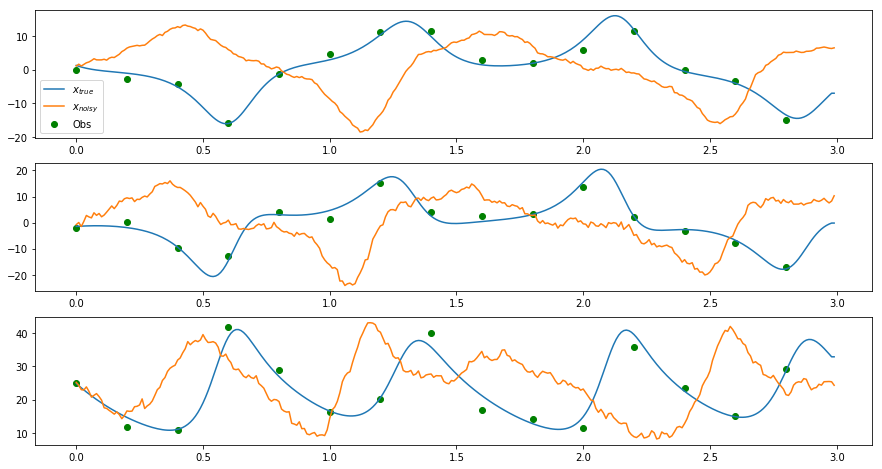

In [10]:
## Plot true state; state evolved with process noise; true state + measurement noise
plt.figure(figsize=[15,8])
plt.subplot(3,1,1) ; plt.plot(t_sys, x_true[0,:],label='$x_{true}$') ; plt.plot(t_sys, x_s[0,:],label='$x_{noisy}$') ; plt.scatter(t_obs, y[0,:],color='green',label='Obs')
plt.legend()
plt.subplot(3,1,2) ; plt.plot(t_sys, x_true[1,:]) ; plt.plot(t_sys, x_s[1,:]) ; plt.scatter(t_obs, y[1,:],color='green')
plt.subplot(3,1,3) ; plt.plot(t_sys, x_true[2,:]) ; plt.plot(t_sys, x_s[2,:]) ; plt.scatter(t_obs, y[2,:],color='green')
plt.show()

### 2. Implement your own EKF to estimate $x_a$. The tangent linear and adjoint codes are provided.
 - Investigate the performance of filter in terms of the bias and mean-square-error of data assimilation analysis. How does the estimate-error computed from $x_a$ and the truth value of $x$ compare to the error variance suggested by the posterior covariance?
 - Examine the sensitivity of the filter performance to the errors in the background. (Compare at least 10 cases)
 - Examine the sensitivity of the filter performance to the accuracy and frequency of observations. Is it better to have frequent but inaccurate observations or infrequent but accurate ones? (Compare at least $10\times 10$ cases.)

In [65]:
# keep constant
A,B,C = coeffs

# initial state
xa = np.array([[x1_0, x2_0, x3_0]], float).T

# initial Background-varience
Pa = B_cov

# R-value?
Msqrt_cov = V*np.sqrt(L)
R = Msqrt_cov

# H is linear here
H = np.eye(3)
I = np.eye(3)

y_mat = np.matrix(y)

xa_EKF = np.matrix(np.zeros([3, 15]))
Pa_EKF = np.zeros(shape=[3,3,15])

obs_times = np.arange(0,N_sys,20)

from scipy import linalg
#for i in range(N_sys):
for i in range(15):
#for i in np.arange(0,300,20):

    x1,x2,x3 = xa
    
    # Tangent Linear Model (M)
    M = np.matrix([
        [-A  ,  A  ,  0.0],
        [B-x3, -1.0,  -x1],
        [x2  , x1  ,  -C]])
    
    #Forecast Step:
    xf = M * xa
    Pf = M * Pa * M.T #+ Qsqrt_cov
    
    #Update Step:
    K = Pf * H.T * np.matrix(R + H*Pf*H.T).I
    xa = xf + K*( y_mat[:,i] - H*xf) # 2x1
    Pa = (I - K*H)*Pf # 2x2
    
    Pa_EKF[:,:,i] = Pa
    xa_EKF[:,i] = xa
    
    
    


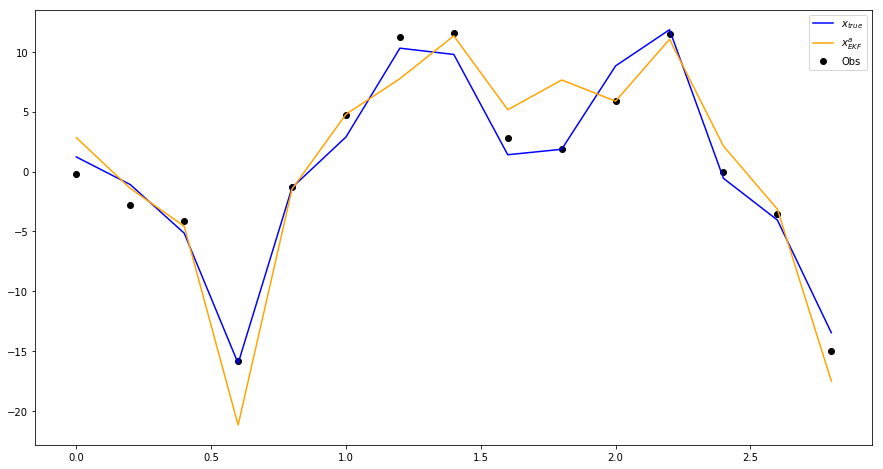

In [66]:
## Plot true state; state evolved with process noise; true state + measurement noise
plt.figure(figsize=[15,8])

plt.plot(t_obs, x_true[0,obs_times],color='blue',label='$x_{true}$')
plt.scatter(t_obs, y[0,:],color='black',label='Obs')
plt.plot(t_obs, np.ravel(xa_EKF[0,:]),color='orange',label='$x^a_{EKF}$')
plt.legend();plt.show()

In [30]:
#x_true[:,obs_times]
y[0,:]

array([ -0.24132326,  -2.81177266,  -4.1445756 , -15.82073585,
        -1.29246861,   4.7276774 ,  11.22689066,  11.54484119,
         2.83938372,   1.86272232,   5.86985061,  11.50513616,
        -0.05317054,  -3.54476672, -14.98408532])

### 3. Implement your own EnKF (with perturb observations) or EnSRF to estimate $x_a$.
 - Initialize the ensemble by introducing small perturbations to the state and integrating the model until its error growth saturates.
 - Compare the performance of the ensemble method to EKF with respect to each sub-question above. Launch ensemble forecasts (instead of deterministic forecasts) at the end of the assimilation period.
 - Evaluate the ensemble by using rank histograms.
 - Examine the impact of increasing or decreasing ensemble size on the filter performance as well as the forecast performance.

In [13]:
np.shape( np.ravel(x_EKF[0,:]) )

(15,)